In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'a')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

슝=3


In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [5]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


In [6]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

슝=3


In [7]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [8]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


In [10]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2022-04-26 08:47:27,871	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.85gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=434) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=434) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=433) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=433) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=432) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=432) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=434) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=434) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_003

(build_single_tfrecord pid=432) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=432) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=433) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=433) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=432) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=432) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0060_of_0064.tfrecords
(build_single_tfrecord pid=434) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=434) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

In [11]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

print('슝=3')

슝=3


In [12]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

print('슝=3')

슝=3


In [13]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('슝=3')

슝=3


In [14]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3
(build_single_tfrecord pid=433) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords


In [15]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


In [16]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


In [17]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


In [18]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


In [19]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


In [20]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

슝=3


In [21]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3


In [22]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 7
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 2.04585862 epoch total loss 2.04585862
Trained batch 2 batch loss 1.86478984 epoch total loss 1.95532417
Trained batch 3 batch loss 2.19289804 epoch total loss 2.03451538
Trained batch 4 batch loss 2.30355406 epoch total loss 2.10177517
Trained batch 5 batch loss 2.38760185 epoch total loss 2.15894055
Trained batch 6 batch loss 2.12926817 epoch total loss 2.15399528
Trained batch 7 batch loss 2.21286535 epoch total loss 2.16240525
Trained batch 8 batch loss 2.03682566 epoch total loss 2.14670777
Trained batch 9 batch loss 2.17191029 epoch total loss 2.14950824
Trained batch 10 batch loss 2.17840052 epoch total loss 2.15239739
Trained batch 11 batch loss 2.1982882 epoch total loss 2.15656924
Trained batch 12 batch loss 2.18599176 epoch total loss 2.15902114
Trained batch 13 batch loss 2.15188217 epoch total loss 2.15847182
Trained batch 14 batch loss 2.10197306 epoch total loss 2.15443635
Trained batch 15 batch loss 2.06124973 ep

Trained batch 123 batch loss 1.7440083 epoch total loss 1.78007269
Trained batch 124 batch loss 1.73437846 epoch total loss 1.77970421
Trained batch 125 batch loss 1.71477163 epoch total loss 1.7791847
Trained batch 126 batch loss 1.73154235 epoch total loss 1.77880657
Trained batch 127 batch loss 1.71863818 epoch total loss 1.77833283
Trained batch 128 batch loss 1.71428227 epoch total loss 1.77783239
Trained batch 129 batch loss 1.69200814 epoch total loss 1.77716708
Trained batch 130 batch loss 1.70019817 epoch total loss 1.77657497
Trained batch 131 batch loss 1.6800046 epoch total loss 1.77583778
Trained batch 132 batch loss 1.60178268 epoch total loss 1.77451909
Trained batch 133 batch loss 1.48971665 epoch total loss 1.77237773
Trained batch 134 batch loss 1.49176121 epoch total loss 1.77028358
Trained batch 135 batch loss 1.47361517 epoch total loss 1.76808608
Trained batch 136 batch loss 1.6986171 epoch total loss 1.76757526
Trained batch 137 batch loss 1.77264118 epoch total 

Trained batch 245 batch loss 1.57867074 epoch total loss 1.70133018
Trained batch 246 batch loss 1.49781311 epoch total loss 1.70050287
Trained batch 247 batch loss 1.59310281 epoch total loss 1.700068
Trained batch 248 batch loss 1.47807598 epoch total loss 1.69917297
Trained batch 249 batch loss 1.52534831 epoch total loss 1.69847488
Trained batch 250 batch loss 1.53746247 epoch total loss 1.69783092
Trained batch 251 batch loss 1.47447085 epoch total loss 1.69694102
Trained batch 252 batch loss 1.44728398 epoch total loss 1.69595039
Trained batch 253 batch loss 1.48843086 epoch total loss 1.69513011
Trained batch 254 batch loss 1.53604269 epoch total loss 1.69450378
Trained batch 255 batch loss 1.52986455 epoch total loss 1.69385815
Trained batch 256 batch loss 1.59321165 epoch total loss 1.69346499
Trained batch 257 batch loss 1.63832057 epoch total loss 1.69325042
Trained batch 258 batch loss 1.62003732 epoch total loss 1.69296658
Trained batch 259 batch loss 1.62097 epoch total l

Trained batch 367 batch loss 1.57864833 epoch total loss 1.65492487
Trained batch 368 batch loss 1.63946688 epoch total loss 1.65488279
Trained batch 369 batch loss 1.60139894 epoch total loss 1.65473783
Trained batch 370 batch loss 1.57688737 epoch total loss 1.65452754
Trained batch 371 batch loss 1.59118605 epoch total loss 1.65435672
Trained batch 372 batch loss 1.55043161 epoch total loss 1.65407729
Trained batch 373 batch loss 1.59206176 epoch total loss 1.65391099
Trained batch 374 batch loss 1.60476816 epoch total loss 1.65377975
Trained batch 375 batch loss 1.57472682 epoch total loss 1.65356886
Trained batch 376 batch loss 1.56433761 epoch total loss 1.65333152
Trained batch 377 batch loss 1.55760372 epoch total loss 1.6530776
Trained batch 378 batch loss 1.54600632 epoch total loss 1.65279436
Trained batch 379 batch loss 1.56342065 epoch total loss 1.65255857
Trained batch 380 batch loss 1.56863785 epoch total loss 1.65233779
Trained batch 381 batch loss 1.48803973 epoch tot

Trained batch 488 batch loss 1.54762709 epoch total loss 1.63736105
Trained batch 489 batch loss 1.55412316 epoch total loss 1.63719082
Trained batch 490 batch loss 1.59906888 epoch total loss 1.63711298
Trained batch 491 batch loss 1.49268746 epoch total loss 1.63681877
Trained batch 492 batch loss 1.54766738 epoch total loss 1.63663757
Trained batch 493 batch loss 1.53076434 epoch total loss 1.63642287
Trained batch 494 batch loss 1.58570528 epoch total loss 1.63632011
Trained batch 495 batch loss 1.63217759 epoch total loss 1.63631189
Trained batch 496 batch loss 1.60075867 epoch total loss 1.63624024
Trained batch 497 batch loss 1.56746209 epoch total loss 1.63610172
Trained batch 498 batch loss 1.54062116 epoch total loss 1.63591015
Trained batch 499 batch loss 1.62925839 epoch total loss 1.6358968
Trained batch 500 batch loss 1.73223805 epoch total loss 1.63608944
Trained batch 501 batch loss 1.71331096 epoch total loss 1.63624358
Trained batch 502 batch loss 1.66233587 epoch tot

Trained batch 609 batch loss 1.50325584 epoch total loss 1.62179887
Trained batch 610 batch loss 1.62623453 epoch total loss 1.62180614
Trained batch 611 batch loss 1.57244563 epoch total loss 1.62172532
Trained batch 612 batch loss 1.54980421 epoch total loss 1.6216079
Trained batch 613 batch loss 1.53162074 epoch total loss 1.62146103
Trained batch 614 batch loss 1.47958183 epoch total loss 1.62122989
Trained batch 615 batch loss 1.52055955 epoch total loss 1.62106621
Trained batch 616 batch loss 1.54580605 epoch total loss 1.62094402
Trained batch 617 batch loss 1.58974206 epoch total loss 1.62089348
Trained batch 618 batch loss 1.51488185 epoch total loss 1.62072194
Trained batch 619 batch loss 1.4605751 epoch total loss 1.62046313
Trained batch 620 batch loss 1.48904705 epoch total loss 1.6202513
Trained batch 621 batch loss 1.52727199 epoch total loss 1.62010157
Trained batch 622 batch loss 1.58668327 epoch total loss 1.62004781
Trained batch 623 batch loss 1.53496432 epoch total

Trained batch 730 batch loss 1.62277174 epoch total loss 1.60444355
Trained batch 731 batch loss 1.67483532 epoch total loss 1.60453975
Trained batch 732 batch loss 1.61577535 epoch total loss 1.60455501
Trained batch 733 batch loss 1.53985822 epoch total loss 1.60446692
Trained batch 734 batch loss 1.36180437 epoch total loss 1.60413623
Trained batch 735 batch loss 1.28953886 epoch total loss 1.60370827
Trained batch 736 batch loss 1.28839731 epoch total loss 1.60328
Trained batch 737 batch loss 1.31489158 epoch total loss 1.6028887
Trained batch 738 batch loss 1.38022804 epoch total loss 1.60258698
Trained batch 739 batch loss 1.49996912 epoch total loss 1.60244823
Trained batch 740 batch loss 1.49794579 epoch total loss 1.60230696
Trained batch 741 batch loss 1.51773798 epoch total loss 1.60219276
Trained batch 742 batch loss 1.49753761 epoch total loss 1.60205173
Trained batch 743 batch loss 1.5129199 epoch total loss 1.60193181
Trained batch 744 batch loss 1.52150953 epoch total l

Trained batch 852 batch loss 1.61717129 epoch total loss 1.58781528
Trained batch 853 batch loss 1.5634253 epoch total loss 1.58778667
Trained batch 854 batch loss 1.52757525 epoch total loss 1.58771622
Trained batch 855 batch loss 1.59313881 epoch total loss 1.58772254
Trained batch 856 batch loss 1.56265521 epoch total loss 1.58769321
Trained batch 857 batch loss 1.47532129 epoch total loss 1.5875622
Trained batch 858 batch loss 1.46170545 epoch total loss 1.58741546
Trained batch 859 batch loss 1.53228426 epoch total loss 1.5873512
Trained batch 860 batch loss 1.58901727 epoch total loss 1.58735311
Trained batch 861 batch loss 1.51455879 epoch total loss 1.58726847
Trained batch 862 batch loss 1.40023065 epoch total loss 1.58705151
Trained batch 863 batch loss 1.48335934 epoch total loss 1.58693147
Trained batch 864 batch loss 1.47117257 epoch total loss 1.58679748
Trained batch 865 batch loss 1.4266305 epoch total loss 1.58661234
Trained batch 866 batch loss 1.4564817 epoch total l

Trained batch 973 batch loss 1.48116267 epoch total loss 1.57504869
Trained batch 974 batch loss 1.41630602 epoch total loss 1.57488561
Trained batch 975 batch loss 1.42174387 epoch total loss 1.57472861
Trained batch 976 batch loss 1.36723375 epoch total loss 1.57451594
Trained batch 977 batch loss 1.43262506 epoch total loss 1.57437062
Trained batch 978 batch loss 1.50829673 epoch total loss 1.57430315
Trained batch 979 batch loss 1.54714179 epoch total loss 1.57427537
Trained batch 980 batch loss 1.48655713 epoch total loss 1.57418585
Trained batch 981 batch loss 1.55176687 epoch total loss 1.57416296
Trained batch 982 batch loss 1.4672178 epoch total loss 1.574054
Trained batch 983 batch loss 1.46071768 epoch total loss 1.57393873
Trained batch 984 batch loss 1.46115541 epoch total loss 1.57382417
Trained batch 985 batch loss 1.5131942 epoch total loss 1.57376254
Trained batch 986 batch loss 1.53245485 epoch total loss 1.57372069
Trained batch 987 batch loss 1.30793428 epoch total 

Trained batch 1093 batch loss 1.56468904 epoch total loss 1.56277847
Trained batch 1094 batch loss 1.70669818 epoch total loss 1.56291
Trained batch 1095 batch loss 1.50701308 epoch total loss 1.56285882
Trained batch 1096 batch loss 1.58472145 epoch total loss 1.56287885
Trained batch 1097 batch loss 1.50713444 epoch total loss 1.56282794
Trained batch 1098 batch loss 1.40889406 epoch total loss 1.56268775
Trained batch 1099 batch loss 1.38647151 epoch total loss 1.56252742
Trained batch 1100 batch loss 1.46411169 epoch total loss 1.56243801
Trained batch 1101 batch loss 1.47928131 epoch total loss 1.56236243
Trained batch 1102 batch loss 1.48293781 epoch total loss 1.56229031
Trained batch 1103 batch loss 1.54103398 epoch total loss 1.562271
Trained batch 1104 batch loss 1.49000311 epoch total loss 1.56220555
Trained batch 1105 batch loss 1.49658287 epoch total loss 1.56214619
Trained batch 1106 batch loss 1.48359609 epoch total loss 1.56207514
Trained batch 1107 batch loss 1.4005928

Trained batch 1213 batch loss 1.59696305 epoch total loss 1.55248857
Trained batch 1214 batch loss 1.59315681 epoch total loss 1.55252206
Trained batch 1215 batch loss 1.40675092 epoch total loss 1.55240202
Trained batch 1216 batch loss 1.51913774 epoch total loss 1.55237472
Trained batch 1217 batch loss 1.41410768 epoch total loss 1.55226099
Trained batch 1218 batch loss 1.40420032 epoch total loss 1.5521394
Trained batch 1219 batch loss 1.39140856 epoch total loss 1.55200756
Trained batch 1220 batch loss 1.49282992 epoch total loss 1.55195904
Trained batch 1221 batch loss 1.43977046 epoch total loss 1.55186713
Trained batch 1222 batch loss 1.52531266 epoch total loss 1.55184543
Trained batch 1223 batch loss 1.44603193 epoch total loss 1.55175889
Trained batch 1224 batch loss 1.46372879 epoch total loss 1.551687
Trained batch 1225 batch loss 1.44044852 epoch total loss 1.55159616
Trained batch 1226 batch loss 1.376544 epoch total loss 1.55145347
Trained batch 1227 batch loss 1.4259811

Trained batch 1333 batch loss 1.42279124 epoch total loss 1.54375505
Trained batch 1334 batch loss 1.45808744 epoch total loss 1.54369068
Trained batch 1335 batch loss 1.45717204 epoch total loss 1.54362595
Trained batch 1336 batch loss 1.39777792 epoch total loss 1.54351676
Trained batch 1337 batch loss 1.38321376 epoch total loss 1.54339695
Trained batch 1338 batch loss 1.35853088 epoch total loss 1.54325891
Trained batch 1339 batch loss 1.33511341 epoch total loss 1.54310346
Trained batch 1340 batch loss 1.32116115 epoch total loss 1.54293776
Trained batch 1341 batch loss 1.33220458 epoch total loss 1.54278064
Trained batch 1342 batch loss 1.33482802 epoch total loss 1.54262567
Trained batch 1343 batch loss 1.31901717 epoch total loss 1.54245925
Trained batch 1344 batch loss 1.38165689 epoch total loss 1.54233956
Trained batch 1345 batch loss 1.28016281 epoch total loss 1.54214466
Trained batch 1346 batch loss 1.35605097 epoch total loss 1.54200637
Trained batch 1347 batch loss 1.31

Validated batch 107 batch loss 1.42789924
Validated batch 108 batch loss 1.40575671
Validated batch 109 batch loss 1.42358208
Validated batch 110 batch loss 1.3100636
Validated batch 111 batch loss 1.34455323
Validated batch 112 batch loss 1.40811098
Validated batch 113 batch loss 1.3063587
Validated batch 114 batch loss 1.43204451
Validated batch 115 batch loss 1.42167652
Validated batch 116 batch loss 1.45346069
Validated batch 117 batch loss 1.41049075
Validated batch 118 batch loss 1.41118693
Validated batch 119 batch loss 1.25380683
Validated batch 120 batch loss 1.32562816
Validated batch 121 batch loss 1.52022922
Validated batch 122 batch loss 1.35496724
Validated batch 123 batch loss 1.34950018
Validated batch 124 batch loss 1.42152381
Validated batch 125 batch loss 1.43498755
Validated batch 126 batch loss 1.37623191
Validated batch 127 batch loss 1.42040682
Validated batch 128 batch loss 1.41494083
Validated batch 129 batch loss 1.37629235
Validated batch 130 batch loss 1.463

Trained batch 72 batch loss 1.32909107 epoch total loss 1.38606095
Trained batch 73 batch loss 1.44886172 epoch total loss 1.38692117
Trained batch 74 batch loss 1.47787023 epoch total loss 1.38815022
Trained batch 75 batch loss 1.32791698 epoch total loss 1.3873471
Trained batch 76 batch loss 1.51812541 epoch total loss 1.38906789
Trained batch 77 batch loss 1.41818047 epoch total loss 1.38944602
Trained batch 78 batch loss 1.49270916 epoch total loss 1.39076984
Trained batch 79 batch loss 1.46551788 epoch total loss 1.391716
Trained batch 80 batch loss 1.66929662 epoch total loss 1.39518571
Trained batch 81 batch loss 1.54500127 epoch total loss 1.39703524
Trained batch 82 batch loss 1.35842371 epoch total loss 1.39656436
Trained batch 83 batch loss 1.27835035 epoch total loss 1.39514017
Trained batch 84 batch loss 1.5200187 epoch total loss 1.39662683
Trained batch 85 batch loss 1.56755185 epoch total loss 1.39863765
Trained batch 86 batch loss 1.48757195 epoch total loss 1.39967179

Trained batch 194 batch loss 1.28205895 epoch total loss 1.4150269
Trained batch 195 batch loss 1.34817302 epoch total loss 1.41468418
Trained batch 196 batch loss 1.43668079 epoch total loss 1.41479635
Trained batch 197 batch loss 1.39348388 epoch total loss 1.41468823
Trained batch 198 batch loss 1.44575357 epoch total loss 1.41484499
Trained batch 199 batch loss 1.49126101 epoch total loss 1.41522908
Trained batch 200 batch loss 1.39054298 epoch total loss 1.41510558
Trained batch 201 batch loss 1.30517161 epoch total loss 1.41455865
Trained batch 202 batch loss 1.38344431 epoch total loss 1.41440463
Trained batch 203 batch loss 1.41457784 epoch total loss 1.41440558
Trained batch 204 batch loss 1.36763263 epoch total loss 1.41417634
Trained batch 205 batch loss 1.29469347 epoch total loss 1.41359353
Trained batch 206 batch loss 1.33555663 epoch total loss 1.4132148
Trained batch 207 batch loss 1.45250583 epoch total loss 1.4134047
Trained batch 208 batch loss 1.35927355 epoch total

Trained batch 315 batch loss 1.35498762 epoch total loss 1.40704632
Trained batch 316 batch loss 1.37250221 epoch total loss 1.406937
Trained batch 317 batch loss 1.3484453 epoch total loss 1.40675259
Trained batch 318 batch loss 1.3323108 epoch total loss 1.40651846
Trained batch 319 batch loss 1.4208014 epoch total loss 1.40656316
Trained batch 320 batch loss 1.37520194 epoch total loss 1.40646529
Trained batch 321 batch loss 1.40650415 epoch total loss 1.40646529
Trained batch 322 batch loss 1.42675 epoch total loss 1.40652835
Trained batch 323 batch loss 1.40021896 epoch total loss 1.4065088
Trained batch 324 batch loss 1.37742138 epoch total loss 1.40641892
Trained batch 325 batch loss 1.389503 epoch total loss 1.40636694
Trained batch 326 batch loss 1.31797409 epoch total loss 1.40609574
Trained batch 327 batch loss 1.3158896 epoch total loss 1.40581989
Trained batch 328 batch loss 1.34215212 epoch total loss 1.40562582
Trained batch 329 batch loss 1.450333 epoch total loss 1.405

Trained batch 437 batch loss 1.56127977 epoch total loss 1.40248501
Trained batch 438 batch loss 1.52280712 epoch total loss 1.40275967
Trained batch 439 batch loss 1.49286532 epoch total loss 1.40296495
Trained batch 440 batch loss 1.42073119 epoch total loss 1.40300524
Trained batch 441 batch loss 1.35328674 epoch total loss 1.40289247
Trained batch 442 batch loss 1.38469326 epoch total loss 1.40285134
Trained batch 443 batch loss 1.44873023 epoch total loss 1.40295494
Trained batch 444 batch loss 1.41873 epoch total loss 1.40299034
Trained batch 445 batch loss 1.35280895 epoch total loss 1.40287757
Trained batch 446 batch loss 1.26733661 epoch total loss 1.4025737
Trained batch 447 batch loss 1.2923975 epoch total loss 1.40232718
Trained batch 448 batch loss 1.25762606 epoch total loss 1.40200424
Trained batch 449 batch loss 1.37361372 epoch total loss 1.40194094
Trained batch 450 batch loss 1.6407578 epoch total loss 1.40247166
Trained batch 451 batch loss 1.61425924 epoch total lo

Trained batch 558 batch loss 1.28467858 epoch total loss 1.39947
Trained batch 559 batch loss 1.40451276 epoch total loss 1.39947903
Trained batch 560 batch loss 1.37502575 epoch total loss 1.39943528
Trained batch 561 batch loss 1.44082546 epoch total loss 1.39950907
Trained batch 562 batch loss 1.37395561 epoch total loss 1.39946353
Trained batch 563 batch loss 1.49802291 epoch total loss 1.39963865
Trained batch 564 batch loss 1.38056302 epoch total loss 1.3996048
Trained batch 565 batch loss 1.38556516 epoch total loss 1.39958
Trained batch 566 batch loss 1.41362953 epoch total loss 1.3996048
Trained batch 567 batch loss 1.28867459 epoch total loss 1.39940917
Trained batch 568 batch loss 1.33889663 epoch total loss 1.3993026
Trained batch 569 batch loss 1.30944324 epoch total loss 1.39914477
Trained batch 570 batch loss 1.35027337 epoch total loss 1.39905894
Trained batch 571 batch loss 1.21451461 epoch total loss 1.39873588
Trained batch 572 batch loss 1.3095454 epoch total loss 1

Trained batch 679 batch loss 1.42856061 epoch total loss 1.39233303
Trained batch 680 batch loss 1.38049173 epoch total loss 1.39231563
Trained batch 681 batch loss 1.39332986 epoch total loss 1.39231718
Trained batch 682 batch loss 1.37631989 epoch total loss 1.39229369
Trained batch 683 batch loss 1.45585942 epoch total loss 1.39238679
Trained batch 684 batch loss 1.39416969 epoch total loss 1.39238942
Trained batch 685 batch loss 1.37527776 epoch total loss 1.3923645
Trained batch 686 batch loss 1.40211368 epoch total loss 1.39237869
Trained batch 687 batch loss 1.3168062 epoch total loss 1.39226866
Trained batch 688 batch loss 1.2927475 epoch total loss 1.39212406
Trained batch 689 batch loss 1.2766273 epoch total loss 1.39195633
Trained batch 690 batch loss 1.43647826 epoch total loss 1.39202082
Trained batch 691 batch loss 1.35919642 epoch total loss 1.39197338
Trained batch 692 batch loss 1.29595053 epoch total loss 1.39183462
Trained batch 693 batch loss 1.25076091 epoch total 

Trained batch 801 batch loss 1.26526356 epoch total loss 1.38492119
Trained batch 802 batch loss 1.36728454 epoch total loss 1.38489926
Trained batch 803 batch loss 1.45675588 epoch total loss 1.38498878
Trained batch 804 batch loss 1.30479336 epoch total loss 1.38488901
Trained batch 805 batch loss 1.20110536 epoch total loss 1.38466072
Trained batch 806 batch loss 1.21767569 epoch total loss 1.38445354
Trained batch 807 batch loss 1.20439601 epoch total loss 1.38423026
Trained batch 808 batch loss 1.28555167 epoch total loss 1.38410819
Trained batch 809 batch loss 1.27535677 epoch total loss 1.38397372
Trained batch 810 batch loss 1.3375057 epoch total loss 1.38391638
Trained batch 811 batch loss 1.3086381 epoch total loss 1.38382351
Trained batch 812 batch loss 1.30588818 epoch total loss 1.38372755
Trained batch 813 batch loss 1.31661415 epoch total loss 1.38364506
Trained batch 814 batch loss 1.43463528 epoch total loss 1.38370776
Trained batch 815 batch loss 1.44502711 epoch tota

Trained batch 923 batch loss 1.45548201 epoch total loss 1.38018858
Trained batch 924 batch loss 1.48957276 epoch total loss 1.38030708
Trained batch 925 batch loss 1.36001706 epoch total loss 1.38028502
Trained batch 926 batch loss 1.44592166 epoch total loss 1.38035595
Trained batch 927 batch loss 1.35868955 epoch total loss 1.38033247
Trained batch 928 batch loss 1.29061496 epoch total loss 1.38023591
Trained batch 929 batch loss 1.28788698 epoch total loss 1.38013637
Trained batch 930 batch loss 1.33700037 epoch total loss 1.38009012
Trained batch 931 batch loss 1.29717898 epoch total loss 1.38000095
Trained batch 932 batch loss 1.30435395 epoch total loss 1.37991977
Trained batch 933 batch loss 1.20037532 epoch total loss 1.37972724
Trained batch 934 batch loss 1.44257474 epoch total loss 1.3797946
Trained batch 935 batch loss 1.52776146 epoch total loss 1.37995279
Trained batch 936 batch loss 1.42111254 epoch total loss 1.37999678
Trained batch 937 batch loss 1.27679527 epoch tot

Trained batch 1044 batch loss 1.31731892 epoch total loss 1.37642741
Trained batch 1045 batch loss 1.31617641 epoch total loss 1.37636971
Trained batch 1046 batch loss 1.19876528 epoch total loss 1.3762
Trained batch 1047 batch loss 1.35711432 epoch total loss 1.3761816
Trained batch 1048 batch loss 1.18186283 epoch total loss 1.37599623
Trained batch 1049 batch loss 1.40104544 epoch total loss 1.37602007
Trained batch 1050 batch loss 1.39310575 epoch total loss 1.37603629
Trained batch 1051 batch loss 1.37678957 epoch total loss 1.37603712
Trained batch 1052 batch loss 1.31003654 epoch total loss 1.37597442
Trained batch 1053 batch loss 1.27032745 epoch total loss 1.37587404
Trained batch 1054 batch loss 1.27388108 epoch total loss 1.37577736
Trained batch 1055 batch loss 1.30559325 epoch total loss 1.37571073
Trained batch 1056 batch loss 1.29658091 epoch total loss 1.37563586
Trained batch 1057 batch loss 1.34612012 epoch total loss 1.37560797
Trained batch 1058 batch loss 1.3531253

Trained batch 1164 batch loss 1.52361894 epoch total loss 1.37347102
Trained batch 1165 batch loss 1.55509257 epoch total loss 1.37362683
Trained batch 1166 batch loss 1.43113232 epoch total loss 1.37367618
Trained batch 1167 batch loss 1.23890185 epoch total loss 1.37356067
Trained batch 1168 batch loss 1.19383347 epoch total loss 1.37340677
Trained batch 1169 batch loss 1.13678455 epoch total loss 1.37320447
Trained batch 1170 batch loss 1.0866468 epoch total loss 1.37295949
Trained batch 1171 batch loss 1.2476747 epoch total loss 1.37285256
Trained batch 1172 batch loss 1.23800325 epoch total loss 1.37273753
Trained batch 1173 batch loss 1.34991813 epoch total loss 1.3727181
Trained batch 1174 batch loss 1.3611877 epoch total loss 1.37270832
Trained batch 1175 batch loss 1.35368323 epoch total loss 1.37269211
Trained batch 1176 batch loss 1.52576101 epoch total loss 1.37282228
Trained batch 1177 batch loss 1.50522673 epoch total loss 1.37293482
Trained batch 1178 batch loss 1.410392

Trained batch 1284 batch loss 1.4075613 epoch total loss 1.36914718
Trained batch 1285 batch loss 1.37301815 epoch total loss 1.36915016
Trained batch 1286 batch loss 1.25636 epoch total loss 1.36906254
Trained batch 1287 batch loss 1.23184788 epoch total loss 1.36895585
Trained batch 1288 batch loss 1.25464189 epoch total loss 1.36886716
Trained batch 1289 batch loss 1.18888736 epoch total loss 1.36872745
Trained batch 1290 batch loss 1.25214946 epoch total loss 1.36863708
Trained batch 1291 batch loss 1.28465414 epoch total loss 1.36857212
Trained batch 1292 batch loss 1.22005057 epoch total loss 1.3684572
Trained batch 1293 batch loss 1.30643892 epoch total loss 1.36840916
Trained batch 1294 batch loss 1.20002985 epoch total loss 1.3682791
Trained batch 1295 batch loss 1.36239266 epoch total loss 1.36827457
Trained batch 1296 batch loss 1.27021718 epoch total loss 1.36819887
Trained batch 1297 batch loss 1.19994378 epoch total loss 1.36806917
Trained batch 1298 batch loss 1.3409586 

Validated batch 25 batch loss 1.30847669
Validated batch 26 batch loss 1.32126689
Validated batch 27 batch loss 1.26650727
Validated batch 28 batch loss 1.36566448
Validated batch 29 batch loss 1.44410539
Validated batch 30 batch loss 1.17437923
Validated batch 31 batch loss 1.3189404
Validated batch 32 batch loss 1.28463674
Validated batch 33 batch loss 1.3815186
Validated batch 34 batch loss 1.32813954
Validated batch 35 batch loss 1.19180453
Validated batch 36 batch loss 1.17334747
Validated batch 37 batch loss 1.28914332
Validated batch 38 batch loss 1.24897277
Validated batch 39 batch loss 1.25175428
Validated batch 40 batch loss 1.28400242
Validated batch 41 batch loss 1.21958113
Validated batch 42 batch loss 1.35407126
Validated batch 43 batch loss 1.34245455
Validated batch 44 batch loss 1.3550154
Validated batch 45 batch loss 1.32175767
Validated batch 46 batch loss 1.20989823
Validated batch 47 batch loss 1.32395935
Validated batch 48 batch loss 1.31331706
Validated batch 49 

Trained batch 22 batch loss 1.28877473 epoch total loss 1.3066777
Trained batch 23 batch loss 1.23461556 epoch total loss 1.30354452
Trained batch 24 batch loss 1.21300912 epoch total loss 1.29977214
Trained batch 25 batch loss 1.2121309 epoch total loss 1.29626644
Trained batch 26 batch loss 1.27001858 epoch total loss 1.29525697
Trained batch 27 batch loss 1.49062812 epoch total loss 1.30249298
Trained batch 28 batch loss 1.38587427 epoch total loss 1.30547082
Trained batch 29 batch loss 1.24288058 epoch total loss 1.30331266
Trained batch 30 batch loss 1.1592654 epoch total loss 1.29851103
Trained batch 31 batch loss 1.17284358 epoch total loss 1.2944572
Trained batch 32 batch loss 1.17931509 epoch total loss 1.29085898
Trained batch 33 batch loss 1.2893554 epoch total loss 1.29081345
Trained batch 34 batch loss 1.32624578 epoch total loss 1.29185557
Trained batch 35 batch loss 1.38360023 epoch total loss 1.29447675
Trained batch 36 batch loss 1.39647162 epoch total loss 1.29731
Tra

Trained batch 145 batch loss 1.42806292 epoch total loss 1.30606568
Trained batch 146 batch loss 1.24621356 epoch total loss 1.30565572
Trained batch 147 batch loss 1.37142682 epoch total loss 1.30610311
Trained batch 148 batch loss 1.44992387 epoch total loss 1.3070749
Trained batch 149 batch loss 1.51044941 epoch total loss 1.30843985
Trained batch 150 batch loss 1.32575941 epoch total loss 1.30855525
Trained batch 151 batch loss 1.29711604 epoch total loss 1.30847955
Trained batch 152 batch loss 1.31117189 epoch total loss 1.30849731
Trained batch 153 batch loss 1.17598 epoch total loss 1.30763113
Trained batch 154 batch loss 1.20349383 epoch total loss 1.30695486
Trained batch 155 batch loss 1.25089359 epoch total loss 1.3065933
Trained batch 156 batch loss 1.25560951 epoch total loss 1.30626655
Trained batch 157 batch loss 1.21273839 epoch total loss 1.30567074
Trained batch 158 batch loss 1.28609014 epoch total loss 1.30554688
Trained batch 159 batch loss 1.43250489 epoch total l

Trained batch 266 batch loss 1.35415757 epoch total loss 1.30446
Trained batch 267 batch loss 1.3360492 epoch total loss 1.3045783
Trained batch 268 batch loss 1.31102371 epoch total loss 1.30460238
Trained batch 269 batch loss 1.23344314 epoch total loss 1.30433786
Trained batch 270 batch loss 1.15775323 epoch total loss 1.30379486
Trained batch 271 batch loss 1.39731216 epoch total loss 1.30414
Trained batch 272 batch loss 1.40525937 epoch total loss 1.30451179
Trained batch 273 batch loss 1.36441505 epoch total loss 1.30473125
Trained batch 274 batch loss 1.29287219 epoch total loss 1.30468798
Trained batch 275 batch loss 1.28885221 epoch total loss 1.3046304
Trained batch 276 batch loss 1.31019092 epoch total loss 1.30465043
Trained batch 277 batch loss 1.18520594 epoch total loss 1.30421925
Trained batch 278 batch loss 1.13955402 epoch total loss 1.30362701
Trained batch 279 batch loss 1.32814956 epoch total loss 1.30371487
Trained batch 280 batch loss 1.37467182 epoch total loss 

Trained batch 387 batch loss 1.27260137 epoch total loss 1.29836857
Trained batch 388 batch loss 1.31262255 epoch total loss 1.29840529
Trained batch 389 batch loss 1.31324494 epoch total loss 1.29844344
Trained batch 390 batch loss 1.30235314 epoch total loss 1.29845345
Trained batch 391 batch loss 1.27150178 epoch total loss 1.29838455
Trained batch 392 batch loss 1.24027848 epoch total loss 1.29823625
Trained batch 393 batch loss 1.31717443 epoch total loss 1.29828453
Trained batch 394 batch loss 1.09754443 epoch total loss 1.29777491
Trained batch 395 batch loss 1.04266882 epoch total loss 1.29712915
Trained batch 396 batch loss 1.25432754 epoch total loss 1.29702115
Trained batch 397 batch loss 1.77813148 epoch total loss 1.29823303
Trained batch 398 batch loss 1.31257665 epoch total loss 1.29826903
Trained batch 399 batch loss 1.2713778 epoch total loss 1.29820156
Trained batch 400 batch loss 1.23412311 epoch total loss 1.29804134
Trained batch 401 batch loss 1.33307528 epoch tot

Trained batch 508 batch loss 1.33524716 epoch total loss 1.29471087
Trained batch 509 batch loss 1.29406047 epoch total loss 1.29470968
Trained batch 510 batch loss 1.29028749 epoch total loss 1.29470098
Trained batch 511 batch loss 1.30119061 epoch total loss 1.29471374
Trained batch 512 batch loss 1.16548896 epoch total loss 1.29446125
Trained batch 513 batch loss 1.32065344 epoch total loss 1.29451239
Trained batch 514 batch loss 1.32930386 epoch total loss 1.29458
Trained batch 515 batch loss 1.47477281 epoch total loss 1.29493
Trained batch 516 batch loss 1.37344337 epoch total loss 1.29508209
Trained batch 517 batch loss 1.22746098 epoch total loss 1.29495132
Trained batch 518 batch loss 1.28542387 epoch total loss 1.29493284
Trained batch 519 batch loss 1.19612825 epoch total loss 1.29474247
Trained batch 520 batch loss 1.43644786 epoch total loss 1.29501498
Trained batch 521 batch loss 1.27653623 epoch total loss 1.29497957
Trained batch 522 batch loss 1.39802063 epoch total lo

Trained batch 630 batch loss 1.52031481 epoch total loss 1.29188156
Trained batch 631 batch loss 1.48553848 epoch total loss 1.29218841
Trained batch 632 batch loss 1.23877728 epoch total loss 1.29210389
Trained batch 633 batch loss 1.25435305 epoch total loss 1.29204428
Trained batch 634 batch loss 1.27998567 epoch total loss 1.29202521
Trained batch 635 batch loss 1.27225101 epoch total loss 1.29199409
Trained batch 636 batch loss 1.26919448 epoch total loss 1.29195821
Trained batch 637 batch loss 1.32694256 epoch total loss 1.29201317
Trained batch 638 batch loss 1.27788126 epoch total loss 1.291991
Trained batch 639 batch loss 1.39475548 epoch total loss 1.29215193
Trained batch 640 batch loss 1.50240707 epoch total loss 1.29248035
Trained batch 641 batch loss 1.36161566 epoch total loss 1.29258823
Trained batch 642 batch loss 1.31444216 epoch total loss 1.29262233
Trained batch 643 batch loss 1.24081576 epoch total loss 1.29254174
Trained batch 644 batch loss 1.22062135 epoch tota

Trained batch 752 batch loss 1.25325072 epoch total loss 1.28782773
Trained batch 753 batch loss 1.4278816 epoch total loss 1.28801358
Trained batch 754 batch loss 1.44532752 epoch total loss 1.28822231
Trained batch 755 batch loss 1.46208632 epoch total loss 1.28845251
Trained batch 756 batch loss 1.36787701 epoch total loss 1.28855753
Trained batch 757 batch loss 1.42330456 epoch total loss 1.28873551
Trained batch 758 batch loss 1.37764585 epoch total loss 1.28885281
Trained batch 759 batch loss 1.34318948 epoch total loss 1.28892446
Trained batch 760 batch loss 1.30954862 epoch total loss 1.28895164
Trained batch 761 batch loss 1.32632959 epoch total loss 1.28900075
Trained batch 762 batch loss 1.29160929 epoch total loss 1.28900421
Trained batch 763 batch loss 1.38721287 epoch total loss 1.28913295
Trained batch 764 batch loss 1.23973775 epoch total loss 1.28906822
Trained batch 765 batch loss 1.22984099 epoch total loss 1.28899086
Trained batch 766 batch loss 1.17003846 epoch tot

Trained batch 873 batch loss 1.15728354 epoch total loss 1.28483534
Trained batch 874 batch loss 1.1477716 epoch total loss 1.28467858
Trained batch 875 batch loss 1.24355674 epoch total loss 1.28463161
Trained batch 876 batch loss 1.0882659 epoch total loss 1.28440738
Trained batch 877 batch loss 1.12756312 epoch total loss 1.28422856
Trained batch 878 batch loss 1.24721599 epoch total loss 1.28418636
Trained batch 879 batch loss 1.22002411 epoch total loss 1.28411329
Trained batch 880 batch loss 1.1520946 epoch total loss 1.28396332
Trained batch 881 batch loss 1.27614927 epoch total loss 1.28395438
Trained batch 882 batch loss 1.54492056 epoch total loss 1.28425026
Trained batch 883 batch loss 1.23360968 epoch total loss 1.28419292
Trained batch 884 batch loss 1.38153148 epoch total loss 1.28430319
Trained batch 885 batch loss 1.45724523 epoch total loss 1.28449857
Trained batch 886 batch loss 1.42763758 epoch total loss 1.2846601
Trained batch 887 batch loss 1.27111614 epoch total 

Trained batch 995 batch loss 1.31153977 epoch total loss 1.28235865
Trained batch 996 batch loss 1.41276932 epoch total loss 1.28248954
Trained batch 997 batch loss 1.181494 epoch total loss 1.28238833
Trained batch 998 batch loss 1.17906797 epoch total loss 1.28228474
Trained batch 999 batch loss 1.27920389 epoch total loss 1.28228164
Trained batch 1000 batch loss 1.2773838 epoch total loss 1.28227675
Trained batch 1001 batch loss 1.22796047 epoch total loss 1.28222239
Trained batch 1002 batch loss 1.38116419 epoch total loss 1.2823211
Trained batch 1003 batch loss 1.42683709 epoch total loss 1.28246522
Trained batch 1004 batch loss 1.41915751 epoch total loss 1.28260136
Trained batch 1005 batch loss 1.23369074 epoch total loss 1.28255272
Trained batch 1006 batch loss 1.27553034 epoch total loss 1.28254569
Trained batch 1007 batch loss 1.32031727 epoch total loss 1.28258324
Trained batch 1008 batch loss 1.22313118 epoch total loss 1.28252423
Trained batch 1009 batch loss 1.37616563 ep

Trained batch 1115 batch loss 1.2263093 epoch total loss 1.28009164
Trained batch 1116 batch loss 1.22847736 epoch total loss 1.28004539
Trained batch 1117 batch loss 1.37179351 epoch total loss 1.28012753
Trained batch 1118 batch loss 1.36133885 epoch total loss 1.28020012
Trained batch 1119 batch loss 1.33443832 epoch total loss 1.28024864
Trained batch 1120 batch loss 1.47173429 epoch total loss 1.28041959
Trained batch 1121 batch loss 1.55008602 epoch total loss 1.28066015
Trained batch 1122 batch loss 1.39422679 epoch total loss 1.28076136
Trained batch 1123 batch loss 1.17842746 epoch total loss 1.28067029
Trained batch 1124 batch loss 1.14822674 epoch total loss 1.28055239
Trained batch 1125 batch loss 1.43969429 epoch total loss 1.28069389
Trained batch 1126 batch loss 1.39456606 epoch total loss 1.28079498
Trained batch 1127 batch loss 1.40840065 epoch total loss 1.28090823
Trained batch 1128 batch loss 1.34830308 epoch total loss 1.28096795
Trained batch 1129 batch loss 1.314

Trained batch 1234 batch loss 1.28623641 epoch total loss 1.28002882
Trained batch 1235 batch loss 1.22191012 epoch total loss 1.27998173
Trained batch 1236 batch loss 1.29213762 epoch total loss 1.27999163
Trained batch 1237 batch loss 1.23660338 epoch total loss 1.27995646
Trained batch 1238 batch loss 1.38795495 epoch total loss 1.28004372
Trained batch 1239 batch loss 1.17297339 epoch total loss 1.27995729
Trained batch 1240 batch loss 1.18083215 epoch total loss 1.27987731
Trained batch 1241 batch loss 1.02844977 epoch total loss 1.27967465
Trained batch 1242 batch loss 1.14903128 epoch total loss 1.27956951
Trained batch 1243 batch loss 1.28305364 epoch total loss 1.27957237
Trained batch 1244 batch loss 1.292961 epoch total loss 1.2795831
Trained batch 1245 batch loss 1.42591572 epoch total loss 1.27970064
Trained batch 1246 batch loss 1.53049397 epoch total loss 1.27990198
Trained batch 1247 batch loss 1.42875433 epoch total loss 1.28002131
Trained batch 1248 batch loss 1.34255

Trained batch 1354 batch loss 1.32288218 epoch total loss 1.27801824
Trained batch 1355 batch loss 1.34539592 epoch total loss 1.27806795
Trained batch 1356 batch loss 1.27418709 epoch total loss 1.27806509
Trained batch 1357 batch loss 1.25633872 epoch total loss 1.27804911
Trained batch 1358 batch loss 1.18391991 epoch total loss 1.27797985
Trained batch 1359 batch loss 1.21915317 epoch total loss 1.27793646
Trained batch 1360 batch loss 1.27887547 epoch total loss 1.27793717
Trained batch 1361 batch loss 1.29081929 epoch total loss 1.27794671
Trained batch 1362 batch loss 1.26329637 epoch total loss 1.27793586
Trained batch 1363 batch loss 1.40004098 epoch total loss 1.27802551
Trained batch 1364 batch loss 1.15866816 epoch total loss 1.27793801
Trained batch 1365 batch loss 1.15193558 epoch total loss 1.27784574
Trained batch 1366 batch loss 1.3606658 epoch total loss 1.27790642
Trained batch 1367 batch loss 1.22517693 epoch total loss 1.27786779
Trained batch 1368 batch loss 1.394

Validated batch 141 batch loss 1.21615601
Validated batch 142 batch loss 1.20324898
Validated batch 143 batch loss 1.19331717
Validated batch 144 batch loss 1.33269477
Validated batch 145 batch loss 1.24310613
Validated batch 146 batch loss 1.34193659
Validated batch 147 batch loss 1.34937167
Validated batch 148 batch loss 1.32516646
Validated batch 149 batch loss 1.27441239
Validated batch 150 batch loss 1.38547182
Validated batch 151 batch loss 1.28732896
Validated batch 152 batch loss 1.32435036
Validated batch 153 batch loss 1.34097266
Validated batch 154 batch loss 1.413257
Validated batch 155 batch loss 1.33220267
Validated batch 156 batch loss 1.22132409
Validated batch 157 batch loss 1.27726901
Validated batch 158 batch loss 1.34649706
Validated batch 159 batch loss 1.32967889
Validated batch 160 batch loss 1.23281479
Validated batch 161 batch loss 1.26782608
Validated batch 162 batch loss 1.32127237
Validated batch 163 batch loss 1.27450919
Validated batch 164 batch loss 1.285

Trained batch 93 batch loss 1.10378313 epoch total loss 1.2565552
Trained batch 94 batch loss 1.18371201 epoch total loss 1.25578034
Trained batch 95 batch loss 1.35931 epoch total loss 1.25687
Trained batch 96 batch loss 1.36215675 epoch total loss 1.25796688
Trained batch 97 batch loss 1.44111407 epoch total loss 1.25985503
Trained batch 98 batch loss 1.24955475 epoch total loss 1.25974989
Trained batch 99 batch loss 1.30873609 epoch total loss 1.26024473
Trained batch 100 batch loss 1.27717602 epoch total loss 1.260414
Trained batch 101 batch loss 1.15772843 epoch total loss 1.25939739
Trained batch 102 batch loss 1.15629804 epoch total loss 1.25838661
Trained batch 103 batch loss 1.18174028 epoch total loss 1.25764263
Trained batch 104 batch loss 1.25333834 epoch total loss 1.25760126
Trained batch 105 batch loss 1.28859293 epoch total loss 1.2578963
Trained batch 106 batch loss 1.28154564 epoch total loss 1.25811934
Trained batch 107 batch loss 1.25381756 epoch total loss 1.258079

Trained batch 215 batch loss 1.25421059 epoch total loss 1.25893867
Trained batch 216 batch loss 1.24575114 epoch total loss 1.25887764
Trained batch 217 batch loss 1.28220749 epoch total loss 1.25898516
Trained batch 218 batch loss 1.32047331 epoch total loss 1.25926709
Trained batch 219 batch loss 1.23420691 epoch total loss 1.25915265
Trained batch 220 batch loss 1.19582498 epoch total loss 1.25886476
Trained batch 221 batch loss 1.34734416 epoch total loss 1.25926518
Trained batch 222 batch loss 1.28781164 epoch total loss 1.25939381
Trained batch 223 batch loss 1.26735032 epoch total loss 1.25942957
Trained batch 224 batch loss 1.2518692 epoch total loss 1.25939572
Trained batch 225 batch loss 1.23580909 epoch total loss 1.25929093
Trained batch 226 batch loss 1.18593 epoch total loss 1.25896633
Trained batch 227 batch loss 1.07453203 epoch total loss 1.2581538
Trained batch 228 batch loss 1.11991358 epoch total loss 1.2575475
Trained batch 229 batch loss 1.20912266 epoch total lo

Trained batch 336 batch loss 1.25724423 epoch total loss 1.24722445
Trained batch 337 batch loss 1.14537811 epoch total loss 1.24692225
Trained batch 338 batch loss 1.25703859 epoch total loss 1.24695218
Trained batch 339 batch loss 1.22279918 epoch total loss 1.24688101
Trained batch 340 batch loss 1.16389453 epoch total loss 1.24663687
Trained batch 341 batch loss 1.34408689 epoch total loss 1.24692261
Trained batch 342 batch loss 1.32543111 epoch total loss 1.24715221
Trained batch 343 batch loss 1.16869318 epoch total loss 1.24692357
Trained batch 344 batch loss 1.36831152 epoch total loss 1.24727643
Trained batch 345 batch loss 1.12298906 epoch total loss 1.24691617
Trained batch 346 batch loss 1.21908236 epoch total loss 1.24683571
Trained batch 347 batch loss 1.25773811 epoch total loss 1.24686718
Trained batch 348 batch loss 1.2453084 epoch total loss 1.24686265
Trained batch 349 batch loss 1.21040285 epoch total loss 1.2467581
Trained batch 350 batch loss 1.30614686 epoch tota

Trained batch 457 batch loss 1.12874198 epoch total loss 1.2413497
Trained batch 458 batch loss 1.27750516 epoch total loss 1.24142873
Trained batch 459 batch loss 1.33001089 epoch total loss 1.24162173
Trained batch 460 batch loss 1.35109246 epoch total loss 1.24185967
Trained batch 461 batch loss 1.24170864 epoch total loss 1.24185932
Trained batch 462 batch loss 1.28957605 epoch total loss 1.24196255
Trained batch 463 batch loss 1.30676734 epoch total loss 1.2421025
Trained batch 464 batch loss 1.2961781 epoch total loss 1.24221909
Trained batch 465 batch loss 1.23598599 epoch total loss 1.24220562
Trained batch 466 batch loss 1.37672257 epoch total loss 1.24249423
Trained batch 467 batch loss 1.26093364 epoch total loss 1.24253368
Trained batch 468 batch loss 1.25653934 epoch total loss 1.24256361
Trained batch 469 batch loss 1.33605933 epoch total loss 1.24276292
Trained batch 470 batch loss 1.30333567 epoch total loss 1.24289191
Trained batch 471 batch loss 1.24010265 epoch total

Trained batch 578 batch loss 1.27851367 epoch total loss 1.23493028
Trained batch 579 batch loss 1.21510041 epoch total loss 1.23489606
Trained batch 580 batch loss 1.13884139 epoch total loss 1.23473048
Trained batch 581 batch loss 1.24132562 epoch total loss 1.23474181
Trained batch 582 batch loss 1.29676104 epoch total loss 1.23484838
Trained batch 583 batch loss 1.3148396 epoch total loss 1.23498559
Trained batch 584 batch loss 1.33712339 epoch total loss 1.23516035
Trained batch 585 batch loss 1.26717103 epoch total loss 1.23521507
Trained batch 586 batch loss 1.27625084 epoch total loss 1.23528516
Trained batch 587 batch loss 1.22094977 epoch total loss 1.23526073
Trained batch 588 batch loss 1.26352453 epoch total loss 1.23530877
Trained batch 589 batch loss 1.25347877 epoch total loss 1.23533964
Trained batch 590 batch loss 1.2156328 epoch total loss 1.23530626
Trained batch 591 batch loss 1.32811093 epoch total loss 1.23546326
Trained batch 592 batch loss 1.27098536 epoch tota

Trained batch 699 batch loss 1.16115153 epoch total loss 1.23188019
Trained batch 700 batch loss 1.22758162 epoch total loss 1.23187411
Trained batch 701 batch loss 1.29860127 epoch total loss 1.23196924
Trained batch 702 batch loss 1.31880534 epoch total loss 1.23209298
Trained batch 703 batch loss 1.42293525 epoch total loss 1.23236442
Trained batch 704 batch loss 1.1742866 epoch total loss 1.23228192
Trained batch 705 batch loss 1.22799325 epoch total loss 1.23227584
Trained batch 706 batch loss 1.21111119 epoch total loss 1.2322458
Trained batch 707 batch loss 1.18268013 epoch total loss 1.23217571
Trained batch 708 batch loss 1.3075397 epoch total loss 1.23228216
Trained batch 709 batch loss 1.07160568 epoch total loss 1.23205554
Trained batch 710 batch loss 1.01510084 epoch total loss 1.23175
Trained batch 711 batch loss 1.03573132 epoch total loss 1.23147428
Trained batch 712 batch loss 1.19207764 epoch total loss 1.23141897
Trained batch 713 batch loss 1.35370743 epoch total lo

Trained batch 821 batch loss 1.26092541 epoch total loss 1.2303896
Trained batch 822 batch loss 1.30594659 epoch total loss 1.23048151
Trained batch 823 batch loss 1.29524922 epoch total loss 1.23056018
Trained batch 824 batch loss 1.33871961 epoch total loss 1.23069143
Trained batch 825 batch loss 1.36524296 epoch total loss 1.23085451
Trained batch 826 batch loss 1.23426676 epoch total loss 1.23085868
Trained batch 827 batch loss 1.24105954 epoch total loss 1.23087108
Trained batch 828 batch loss 1.37236702 epoch total loss 1.23104191
Trained batch 829 batch loss 1.30361092 epoch total loss 1.23112941
Trained batch 830 batch loss 1.35100162 epoch total loss 1.23127389
Trained batch 831 batch loss 1.24124932 epoch total loss 1.23128593
Trained batch 832 batch loss 1.25244641 epoch total loss 1.23131132
Trained batch 833 batch loss 1.26527917 epoch total loss 1.23135209
Trained batch 834 batch loss 1.28922808 epoch total loss 1.23142147
Trained batch 835 batch loss 1.24845839 epoch tot

Trained batch 942 batch loss 1.33435106 epoch total loss 1.23022318
Trained batch 943 batch loss 1.2240026 epoch total loss 1.23021662
Trained batch 944 batch loss 1.22005677 epoch total loss 1.23020589
Trained batch 945 batch loss 1.26430285 epoch total loss 1.23024189
Trained batch 946 batch loss 1.1518786 epoch total loss 1.23015904
Trained batch 947 batch loss 1.20173383 epoch total loss 1.23012912
Trained batch 948 batch loss 1.16826379 epoch total loss 1.2300638
Trained batch 949 batch loss 1.15978205 epoch total loss 1.22998977
Trained batch 950 batch loss 1.11209548 epoch total loss 1.22986555
Trained batch 951 batch loss 1.06740117 epoch total loss 1.22969472
Trained batch 952 batch loss 1.14661443 epoch total loss 1.22960746
Trained batch 953 batch loss 1.13152254 epoch total loss 1.22950447
Trained batch 954 batch loss 1.30552804 epoch total loss 1.22958422
Trained batch 955 batch loss 1.19204211 epoch total loss 1.22954488
Trained batch 956 batch loss 1.19726634 epoch total

Trained batch 1063 batch loss 1.33843541 epoch total loss 1.22630668
Trained batch 1064 batch loss 1.17465 epoch total loss 1.22625816
Trained batch 1065 batch loss 1.18622351 epoch total loss 1.22622061
Trained batch 1066 batch loss 1.3638109 epoch total loss 1.22634959
Trained batch 1067 batch loss 1.14704645 epoch total loss 1.22627532
Trained batch 1068 batch loss 1.12450469 epoch total loss 1.22618008
Trained batch 1069 batch loss 1.17946839 epoch total loss 1.22613633
Trained batch 1070 batch loss 1.09678578 epoch total loss 1.22601545
Trained batch 1071 batch loss 1.09675348 epoch total loss 1.22589481
Trained batch 1072 batch loss 1.02149892 epoch total loss 1.22570419
Trained batch 1073 batch loss 1.08125961 epoch total loss 1.22556961
Trained batch 1074 batch loss 1.0818572 epoch total loss 1.22543573
Trained batch 1075 batch loss 1.09680092 epoch total loss 1.22531617
Trained batch 1076 batch loss 1.12011433 epoch total loss 1.22521842
Trained batch 1077 batch loss 1.0528709

Trained batch 1183 batch loss 1.22169161 epoch total loss 1.22668207
Trained batch 1184 batch loss 1.26080668 epoch total loss 1.22671092
Trained batch 1185 batch loss 1.34326625 epoch total loss 1.22680926
Trained batch 1186 batch loss 1.25844169 epoch total loss 1.22683597
Trained batch 1187 batch loss 1.30864596 epoch total loss 1.22690487
Trained batch 1188 batch loss 1.26495397 epoch total loss 1.22693694
Trained batch 1189 batch loss 1.40962529 epoch total loss 1.2270906
Trained batch 1190 batch loss 1.2882036 epoch total loss 1.22714198
Trained batch 1191 batch loss 1.35754967 epoch total loss 1.22725141
Trained batch 1192 batch loss 1.23436558 epoch total loss 1.22725749
Trained batch 1193 batch loss 1.45466018 epoch total loss 1.22744811
Trained batch 1194 batch loss 1.50385058 epoch total loss 1.22767961
Trained batch 1195 batch loss 1.22422755 epoch total loss 1.22767675
Trained batch 1196 batch loss 1.37945676 epoch total loss 1.22780371
Trained batch 1197 batch loss 1.2311

Trained batch 1303 batch loss 1.20821095 epoch total loss 1.22657585
Trained batch 1304 batch loss 1.24980593 epoch total loss 1.22659361
Trained batch 1305 batch loss 1.32127392 epoch total loss 1.22666609
Trained batch 1306 batch loss 1.26539063 epoch total loss 1.22669578
Trained batch 1307 batch loss 1.3546263 epoch total loss 1.22679365
Trained batch 1308 batch loss 1.29526699 epoch total loss 1.22684598
Trained batch 1309 batch loss 1.24160802 epoch total loss 1.2268573
Trained batch 1310 batch loss 1.17247629 epoch total loss 1.22681582
Trained batch 1311 batch loss 1.19960225 epoch total loss 1.22679496
Trained batch 1312 batch loss 1.30597019 epoch total loss 1.2268554
Trained batch 1313 batch loss 1.30199718 epoch total loss 1.22691262
Trained batch 1314 batch loss 1.38659716 epoch total loss 1.22703421
Trained batch 1315 batch loss 1.46349 epoch total loss 1.22721398
Trained batch 1316 batch loss 1.24746132 epoch total loss 1.22722936
Trained batch 1317 batch loss 1.28884792

Validated batch 57 batch loss 1.23791742
Validated batch 58 batch loss 1.18681955
Validated batch 59 batch loss 1.22635579
Validated batch 60 batch loss 1.33178627
Validated batch 61 batch loss 1.30468249
Validated batch 62 batch loss 1.21441329
Validated batch 63 batch loss 1.41246879
Validated batch 64 batch loss 1.05808568
Validated batch 65 batch loss 1.28041804
Validated batch 66 batch loss 1.03699803
Validated batch 67 batch loss 1.1860249
Validated batch 68 batch loss 1.3063947
Validated batch 69 batch loss 1.14084744
Validated batch 70 batch loss 1.14204609
Validated batch 71 batch loss 1.06869602
Validated batch 72 batch loss 1.19656157
Validated batch 73 batch loss 1.15313268
Validated batch 74 batch loss 1.14469063
Validated batch 75 batch loss 1.23614156
Validated batch 76 batch loss 1.20319939
Validated batch 77 batch loss 1.11905777
Validated batch 78 batch loss 1.23540449
Validated batch 79 batch loss 1.12603307
Validated batch 80 batch loss 1.22600698
Validated batch 81

Trained batch 41 batch loss 1.08725572 epoch total loss 1.14883316
Trained batch 42 batch loss 1.10529613 epoch total loss 1.14779663
Trained batch 43 batch loss 1.1043961 epoch total loss 1.14678729
Trained batch 44 batch loss 1.25496125 epoch total loss 1.14924586
Trained batch 45 batch loss 1.20994246 epoch total loss 1.15059471
Trained batch 46 batch loss 1.18559468 epoch total loss 1.15135562
Trained batch 47 batch loss 1.32161152 epoch total loss 1.15497804
Trained batch 48 batch loss 1.09117365 epoch total loss 1.15364885
Trained batch 49 batch loss 1.15789104 epoch total loss 1.1537354
Trained batch 50 batch loss 1.11540985 epoch total loss 1.15296888
Trained batch 51 batch loss 1.20392442 epoch total loss 1.1539681
Trained batch 52 batch loss 1.18872774 epoch total loss 1.1546365
Trained batch 53 batch loss 1.16682541 epoch total loss 1.15486646
Trained batch 54 batch loss 1.14387548 epoch total loss 1.15466297
Trained batch 55 batch loss 1.22557473 epoch total loss 1.15595222

Trained batch 163 batch loss 1.26791167 epoch total loss 1.17070401
Trained batch 164 batch loss 1.36444545 epoch total loss 1.17188537
Trained batch 165 batch loss 1.19011235 epoch total loss 1.17199576
Trained batch 166 batch loss 1.1037457 epoch total loss 1.17158461
Trained batch 167 batch loss 1.1113565 epoch total loss 1.171224
Trained batch 168 batch loss 1.19087267 epoch total loss 1.17134094
Trained batch 169 batch loss 1.259547 epoch total loss 1.17186296
Trained batch 170 batch loss 1.3300755 epoch total loss 1.17279363
Trained batch 171 batch loss 1.25638056 epoch total loss 1.17328238
Trained batch 172 batch loss 1.24672294 epoch total loss 1.17370939
Trained batch 173 batch loss 1.12053561 epoch total loss 1.17340195
Trained batch 174 batch loss 1.08246267 epoch total loss 1.17287922
Trained batch 175 batch loss 1.18847847 epoch total loss 1.17296839
Trained batch 176 batch loss 1.23315096 epoch total loss 1.1733104
Trained batch 177 batch loss 1.25648475 epoch total loss

Trained batch 284 batch loss 1.26547861 epoch total loss 1.19795644
Trained batch 285 batch loss 1.20530486 epoch total loss 1.19798219
Trained batch 286 batch loss 1.33842242 epoch total loss 1.19847322
Trained batch 287 batch loss 1.26959538 epoch total loss 1.19872105
Trained batch 288 batch loss 1.17352533 epoch total loss 1.19863355
Trained batch 289 batch loss 1.21433365 epoch total loss 1.19868779
Trained batch 290 batch loss 1.21495175 epoch total loss 1.19874394
Trained batch 291 batch loss 1.12394691 epoch total loss 1.1984868
Trained batch 292 batch loss 1.07867277 epoch total loss 1.19807649
Trained batch 293 batch loss 1.15264702 epoch total loss 1.19792151
Trained batch 294 batch loss 1.12139022 epoch total loss 1.19766116
Trained batch 295 batch loss 1.33410585 epoch total loss 1.19812369
Trained batch 296 batch loss 1.43085814 epoch total loss 1.19891
Trained batch 297 batch loss 1.40437579 epoch total loss 1.19960177
Trained batch 298 batch loss 1.28317225 epoch total 

Trained batch 405 batch loss 1.45613563 epoch total loss 1.19342
Trained batch 406 batch loss 1.40610886 epoch total loss 1.19394386
Trained batch 407 batch loss 1.14744151 epoch total loss 1.19382954
Trained batch 408 batch loss 1.10241699 epoch total loss 1.19360554
Trained batch 409 batch loss 1.2870568 epoch total loss 1.19383395
Trained batch 410 batch loss 1.29823065 epoch total loss 1.19408858
Trained batch 411 batch loss 1.33310115 epoch total loss 1.19442677
Trained batch 412 batch loss 1.28231037 epoch total loss 1.19464016
Trained batch 413 batch loss 1.30773747 epoch total loss 1.19491398
Trained batch 414 batch loss 1.24052298 epoch total loss 1.19502413
Trained batch 415 batch loss 1.20345867 epoch total loss 1.19504452
Trained batch 416 batch loss 1.10002661 epoch total loss 1.19481611
Trained batch 417 batch loss 1.16303229 epoch total loss 1.19473982
Trained batch 418 batch loss 1.16304851 epoch total loss 1.194664
Trained batch 419 batch loss 1.14656758 epoch total lo

Trained batch 526 batch loss 1.16276383 epoch total loss 1.19032824
Trained batch 527 batch loss 1.0185045 epoch total loss 1.1900022
Trained batch 528 batch loss 1.09666061 epoch total loss 1.18982542
Trained batch 529 batch loss 1.23248661 epoch total loss 1.18990612
Trained batch 530 batch loss 1.04190445 epoch total loss 1.18962693
Trained batch 531 batch loss 1.30015361 epoch total loss 1.18983507
Trained batch 532 batch loss 0.933105469 epoch total loss 1.18935251
Trained batch 533 batch loss 1.11056578 epoch total loss 1.18920469
Trained batch 534 batch loss 1.11095607 epoch total loss 1.18905818
Trained batch 535 batch loss 1.15463364 epoch total loss 1.18899393
Trained batch 536 batch loss 1.24570692 epoch total loss 1.18909979
Trained batch 537 batch loss 1.27289426 epoch total loss 1.18925583
Trained batch 538 batch loss 1.42478013 epoch total loss 1.18969369
Trained batch 539 batch loss 1.2770412 epoch total loss 1.18985569
Trained batch 540 batch loss 1.15473843 epoch tota

Trained batch 648 batch loss 1.23332644 epoch total loss 1.19171083
Trained batch 649 batch loss 1.21048248 epoch total loss 1.1917398
Trained batch 650 batch loss 1.08848941 epoch total loss 1.19158101
Trained batch 651 batch loss 1.24727774 epoch total loss 1.19166648
Trained batch 652 batch loss 1.15961945 epoch total loss 1.19161737
Trained batch 653 batch loss 1.15887475 epoch total loss 1.19156718
Trained batch 654 batch loss 1.2524364 epoch total loss 1.19166028
Trained batch 655 batch loss 1.21344209 epoch total loss 1.19169354
Trained batch 656 batch loss 1.17185283 epoch total loss 1.19166327
Trained batch 657 batch loss 1.38314807 epoch total loss 1.19195473
Trained batch 658 batch loss 1.24762368 epoch total loss 1.19203937
Trained batch 659 batch loss 1.16839576 epoch total loss 1.19200349
Trained batch 660 batch loss 1.1511699 epoch total loss 1.19194162
Trained batch 661 batch loss 1.26294231 epoch total loss 1.19204903
Trained batch 662 batch loss 1.26572061 epoch total

Trained batch 770 batch loss 1.21468639 epoch total loss 1.19141352
Trained batch 771 batch loss 1.21213782 epoch total loss 1.19144034
Trained batch 772 batch loss 1.19340205 epoch total loss 1.19144297
Trained batch 773 batch loss 1.15072441 epoch total loss 1.19139028
Trained batch 774 batch loss 1.14736199 epoch total loss 1.19133329
Trained batch 775 batch loss 1.20912302 epoch total loss 1.19135618
Trained batch 776 batch loss 1.20982623 epoch total loss 1.19138
Trained batch 777 batch loss 1.2476052 epoch total loss 1.19145238
Trained batch 778 batch loss 1.23693991 epoch total loss 1.19151092
Trained batch 779 batch loss 1.24581385 epoch total loss 1.19158053
Trained batch 780 batch loss 1.27906406 epoch total loss 1.19169271
Trained batch 781 batch loss 1.21621716 epoch total loss 1.19172418
Trained batch 782 batch loss 1.21061087 epoch total loss 1.19174838
Trained batch 783 batch loss 1.10086846 epoch total loss 1.19163227
Trained batch 784 batch loss 1.08159494 epoch total 

Trained batch 892 batch loss 1.13422143 epoch total loss 1.18981957
Trained batch 893 batch loss 1.24513543 epoch total loss 1.18988156
Trained batch 894 batch loss 1.37942994 epoch total loss 1.19009352
Trained batch 895 batch loss 1.30451322 epoch total loss 1.19022143
Trained batch 896 batch loss 1.17955589 epoch total loss 1.19020951
Trained batch 897 batch loss 1.19097388 epoch total loss 1.19021034
Trained batch 898 batch loss 1.15758467 epoch total loss 1.19017398
Trained batch 899 batch loss 1.1782769 epoch total loss 1.19016075
Trained batch 900 batch loss 1.31061423 epoch total loss 1.19029462
Trained batch 901 batch loss 1.2815156 epoch total loss 1.19039583
Trained batch 902 batch loss 1.35257435 epoch total loss 1.1905756
Trained batch 903 batch loss 1.46285677 epoch total loss 1.1908772
Trained batch 904 batch loss 1.2331835 epoch total loss 1.19092393
Trained batch 905 batch loss 1.31897295 epoch total loss 1.19106543
Trained batch 906 batch loss 1.2238028 epoch total lo

Trained batch 1013 batch loss 1.2337873 epoch total loss 1.1885556
Trained batch 1014 batch loss 1.20047152 epoch total loss 1.18856728
Trained batch 1015 batch loss 1.17097759 epoch total loss 1.18855
Trained batch 1016 batch loss 1.1793859 epoch total loss 1.18854105
Trained batch 1017 batch loss 1.14651 epoch total loss 1.18849969
Trained batch 1018 batch loss 1.20132887 epoch total loss 1.18851233
Trained batch 1019 batch loss 1.29516 epoch total loss 1.18861699
Trained batch 1020 batch loss 1.27820504 epoch total loss 1.18870473
Trained batch 1021 batch loss 1.39061832 epoch total loss 1.1889025
Trained batch 1022 batch loss 1.29283309 epoch total loss 1.1890043
Trained batch 1023 batch loss 1.16126084 epoch total loss 1.18897712
Trained batch 1024 batch loss 1.23778391 epoch total loss 1.18902481
Trained batch 1025 batch loss 1.24772108 epoch total loss 1.18908203
Trained batch 1026 batch loss 1.1477102 epoch total loss 1.18904173
Trained batch 1027 batch loss 1.14179766 epoch to

Trained batch 1133 batch loss 0.981220126 epoch total loss 1.18813801
Trained batch 1134 batch loss 1.13434052 epoch total loss 1.18809068
Trained batch 1135 batch loss 1.18505502 epoch total loss 1.18808794
Trained batch 1136 batch loss 1.26403379 epoch total loss 1.18815482
Trained batch 1137 batch loss 1.41500974 epoch total loss 1.18835437
Trained batch 1138 batch loss 1.37022161 epoch total loss 1.18851423
Trained batch 1139 batch loss 1.25614643 epoch total loss 1.1885736
Trained batch 1140 batch loss 1.21185708 epoch total loss 1.18859398
Trained batch 1141 batch loss 1.17567253 epoch total loss 1.18858266
Trained batch 1142 batch loss 1.06635511 epoch total loss 1.18847573
Trained batch 1143 batch loss 1.07165325 epoch total loss 1.18837345
Trained batch 1144 batch loss 1.26038194 epoch total loss 1.18843639
Trained batch 1145 batch loss 1.22084701 epoch total loss 1.18846476
Trained batch 1146 batch loss 1.15104592 epoch total loss 1.18843198
Trained batch 1147 batch loss 1.12

Trained batch 1253 batch loss 1.11752331 epoch total loss 1.18765485
Trained batch 1254 batch loss 1.31164873 epoch total loss 1.1877538
Trained batch 1255 batch loss 1.45197535 epoch total loss 1.18796432
Trained batch 1256 batch loss 1.19603539 epoch total loss 1.18797076
Trained batch 1257 batch loss 1.16293883 epoch total loss 1.18795085
Trained batch 1258 batch loss 1.13871741 epoch total loss 1.18791175
Trained batch 1259 batch loss 1.1683917 epoch total loss 1.18789613
Trained batch 1260 batch loss 1.45769155 epoch total loss 1.18811023
Trained batch 1261 batch loss 1.35370421 epoch total loss 1.1882416
Trained batch 1262 batch loss 1.28990877 epoch total loss 1.18832219
Trained batch 1263 batch loss 1.41206586 epoch total loss 1.18849933
Trained batch 1264 batch loss 1.25708342 epoch total loss 1.18855357
Trained batch 1265 batch loss 1.22775269 epoch total loss 1.18858469
Trained batch 1266 batch loss 1.18432868 epoch total loss 1.18858123
Trained batch 1267 batch loss 1.26359

Trained batch 1373 batch loss 1.25434756 epoch total loss 1.18588459
Trained batch 1374 batch loss 1.21049523 epoch total loss 1.18590248
Trained batch 1375 batch loss 1.24786389 epoch total loss 1.18594754
Trained batch 1376 batch loss 1.25163507 epoch total loss 1.18599522
Trained batch 1377 batch loss 1.13333201 epoch total loss 1.18595695
Trained batch 1378 batch loss 1.11565387 epoch total loss 1.18590593
Trained batch 1379 batch loss 1.04408288 epoch total loss 1.18580306
Trained batch 1380 batch loss 1.15003157 epoch total loss 1.18577719
Trained batch 1381 batch loss 1.16299236 epoch total loss 1.18576062
Trained batch 1382 batch loss 1.35213017 epoch total loss 1.18588102
Trained batch 1383 batch loss 1.28150213 epoch total loss 1.18595016
Trained batch 1384 batch loss 1.23852706 epoch total loss 1.18598819
Trained batch 1385 batch loss 1.16577685 epoch total loss 1.18597353
Trained batch 1386 batch loss 1.12062645 epoch total loss 1.18592644
Trained batch 1387 batch loss 1.12

Validated batch 173 batch loss 1.24863064
Validated batch 174 batch loss 1.19209898
Validated batch 175 batch loss 1.31927586
Validated batch 176 batch loss 1.3856585
Validated batch 177 batch loss 1.18892288
Validated batch 178 batch loss 1.31269228
Validated batch 179 batch loss 1.22387576
Validated batch 180 batch loss 1.14088094
Validated batch 181 batch loss 1.22210479
Validated batch 182 batch loss 1.08010316
Validated batch 183 batch loss 1.27810752
Validated batch 184 batch loss 1.15118444
Validated batch 185 batch loss 1.25828934
Epoch 5 val loss 1.2117691040039062
Start epoch 6 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 1.34837627 epoch total loss 1.34837627
Trained batch 2 batch loss 1.22110009 epoch total loss 1.28473818
Trained batch 3 batch loss 1.08410263 epoch total loss 1.21785963
Trained batch 4 batch loss 1.02915418 epoch total loss 1.17068326
Trained batch 5 batch loss 1.09732068 epoch total loss 1.15601075
Trained batch 6 ba

Trained batch 114 batch loss 1.11259878 epoch total loss 1.1320442
Trained batch 115 batch loss 1.14312112 epoch total loss 1.13214064
Trained batch 116 batch loss 1.30771 epoch total loss 1.13365412
Trained batch 117 batch loss 1.12441945 epoch total loss 1.1335752
Trained batch 118 batch loss 1.12859297 epoch total loss 1.13353288
Trained batch 119 batch loss 1.13858247 epoch total loss 1.13357532
Trained batch 120 batch loss 1.12973571 epoch total loss 1.13354325
Trained batch 121 batch loss 1.1987468 epoch total loss 1.13408208
Trained batch 122 batch loss 1.20323014 epoch total loss 1.13464892
Trained batch 123 batch loss 1.18489289 epoch total loss 1.13505745
Trained batch 124 batch loss 1.17867303 epoch total loss 1.13540924
Trained batch 125 batch loss 1.16923356 epoch total loss 1.13567984
Trained batch 126 batch loss 1.04090226 epoch total loss 1.13492763
Trained batch 127 batch loss 1.11248505 epoch total loss 1.13475096
Trained batch 128 batch loss 1.17569733 epoch total lo

Trained batch 235 batch loss 1.09641314 epoch total loss 1.14013779
Trained batch 236 batch loss 1.13523936 epoch total loss 1.14011705
Trained batch 237 batch loss 1.08268952 epoch total loss 1.13987482
Trained batch 238 batch loss 1.08215654 epoch total loss 1.13963223
Trained batch 239 batch loss 1.17500353 epoch total loss 1.13978028
Trained batch 240 batch loss 1.23863554 epoch total loss 1.14019227
Trained batch 241 batch loss 1.1511426 epoch total loss 1.14023781
Trained batch 242 batch loss 1.23459458 epoch total loss 1.14062762
Trained batch 243 batch loss 1.17997825 epoch total loss 1.14078963
Trained batch 244 batch loss 1.18123507 epoch total loss 1.14095545
Trained batch 245 batch loss 1.01269674 epoch total loss 1.14043188
Trained batch 246 batch loss 1.19482303 epoch total loss 1.14065301
Trained batch 247 batch loss 1.09546733 epoch total loss 1.14047
Trained batch 248 batch loss 0.940076232 epoch total loss 1.13966203
Trained batch 249 batch loss 0.990270734 epoch tota

Trained batch 356 batch loss 1.12417269 epoch total loss 1.14029431
Trained batch 357 batch loss 1.21022749 epoch total loss 1.14049029
Trained batch 358 batch loss 1.21483326 epoch total loss 1.14069796
Trained batch 359 batch loss 1.10917568 epoch total loss 1.1406101
Trained batch 360 batch loss 1.08121562 epoch total loss 1.14044511
Trained batch 361 batch loss 1.07660317 epoch total loss 1.14026821
Trained batch 362 batch loss 1.21876717 epoch total loss 1.14048517
Trained batch 363 batch loss 1.25222921 epoch total loss 1.14079297
Trained batch 364 batch loss 1.29175556 epoch total loss 1.1412077
Trained batch 365 batch loss 1.32391298 epoch total loss 1.14170825
Trained batch 366 batch loss 1.23865128 epoch total loss 1.14197314
Trained batch 367 batch loss 1.25723302 epoch total loss 1.14228714
Trained batch 368 batch loss 1.11702275 epoch total loss 1.14221859
Trained batch 369 batch loss 1.08233428 epoch total loss 1.14205623
Trained batch 370 batch loss 1.25419617 epoch tota

Trained batch 477 batch loss 0.977351069 epoch total loss 1.1458751
Trained batch 478 batch loss 1.14546871 epoch total loss 1.14587414
Trained batch 479 batch loss 1.26398897 epoch total loss 1.14612067
Trained batch 480 batch loss 1.39068484 epoch total loss 1.14663017
Trained batch 481 batch loss 1.32044518 epoch total loss 1.14699161
Trained batch 482 batch loss 1.2378881 epoch total loss 1.1471802
Trained batch 483 batch loss 1.19506562 epoch total loss 1.14727938
Trained batch 484 batch loss 1.14390194 epoch total loss 1.14727247
Trained batch 485 batch loss 1.00477707 epoch total loss 1.14697862
Trained batch 486 batch loss 1.20151925 epoch total loss 1.14709079
Trained batch 487 batch loss 1.13451457 epoch total loss 1.14706504
Trained batch 488 batch loss 1.18720424 epoch total loss 1.1471473
Trained batch 489 batch loss 1.03827965 epoch total loss 1.14692461
Trained batch 490 batch loss 1.02370846 epoch total loss 1.14667308
Trained batch 491 batch loss 0.986553252 epoch tota

Trained batch 598 batch loss 1.26950336 epoch total loss 1.15104818
Trained batch 599 batch loss 1.12217081 epoch total loss 1.151
Trained batch 600 batch loss 1.12956178 epoch total loss 1.15096438
Trained batch 601 batch loss 1.04366684 epoch total loss 1.1507858
Trained batch 602 batch loss 1.26256394 epoch total loss 1.15097153
Trained batch 603 batch loss 1.28063881 epoch total loss 1.15118647
Trained batch 604 batch loss 1.23934698 epoch total loss 1.15133238
Trained batch 605 batch loss 1.23723137 epoch total loss 1.15147448
Trained batch 606 batch loss 1.14164102 epoch total loss 1.15145826
Trained batch 607 batch loss 1.20241261 epoch total loss 1.15154219
Trained batch 608 batch loss 1.12193513 epoch total loss 1.15149343
Trained batch 609 batch loss 1.15574932 epoch total loss 1.15150046
Trained batch 610 batch loss 1.30187738 epoch total loss 1.15174699
Trained batch 611 batch loss 1.24815774 epoch total loss 1.15190482
Trained batch 612 batch loss 1.24130309 epoch total lo

Trained batch 719 batch loss 1.23188806 epoch total loss 1.15470541
Trained batch 720 batch loss 1.2165482 epoch total loss 1.15479136
Trained batch 721 batch loss 1.11614168 epoch total loss 1.15473771
Trained batch 722 batch loss 1.07949519 epoch total loss 1.15463352
Trained batch 723 batch loss 1.31619227 epoch total loss 1.15485692
Trained batch 724 batch loss 1.31960571 epoch total loss 1.15508437
Trained batch 725 batch loss 1.06997275 epoch total loss 1.15496695
Trained batch 726 batch loss 1.07599449 epoch total loss 1.15485823
Trained batch 727 batch loss 1.00022686 epoch total loss 1.15464556
Trained batch 728 batch loss 0.985135436 epoch total loss 1.15441263
Trained batch 729 batch loss 0.984735906 epoch total loss 1.15417993
Trained batch 730 batch loss 0.935597241 epoch total loss 1.15388048
Trained batch 731 batch loss 1.08918905 epoch total loss 1.15379202
Trained batch 732 batch loss 1.10803306 epoch total loss 1.15372944
Trained batch 733 batch loss 1.05983067 epoch 

Trained batch 840 batch loss 1.07424855 epoch total loss 1.15175891
Trained batch 841 batch loss 1.06207418 epoch total loss 1.15165222
Trained batch 842 batch loss 1.23716283 epoch total loss 1.15175378
Trained batch 843 batch loss 1.2411865 epoch total loss 1.15186
Trained batch 844 batch loss 1.26799536 epoch total loss 1.15199757
Trained batch 845 batch loss 1.20137382 epoch total loss 1.15205598
Trained batch 846 batch loss 1.25505805 epoch total loss 1.15217769
Trained batch 847 batch loss 1.24834156 epoch total loss 1.1522913
Trained batch 848 batch loss 1.10313642 epoch total loss 1.15223336
Trained batch 849 batch loss 1.16105711 epoch total loss 1.15224373
Trained batch 850 batch loss 1.28487635 epoch total loss 1.15239978
Trained batch 851 batch loss 1.1296072 epoch total loss 1.15237296
Trained batch 852 batch loss 0.987352252 epoch total loss 1.15217924
Trained batch 853 batch loss 1.07848883 epoch total loss 1.15209293
Trained batch 854 batch loss 1.2001524 epoch total lo

Trained batch 962 batch loss 1.050668 epoch total loss 1.15536165
Trained batch 963 batch loss 1.06410456 epoch total loss 1.15526688
Trained batch 964 batch loss 1.05371642 epoch total loss 1.1551615
Trained batch 965 batch loss 1.19662929 epoch total loss 1.15520453
Trained batch 966 batch loss 1.24938726 epoch total loss 1.15530205
Trained batch 967 batch loss 1.23258376 epoch total loss 1.15538192
Trained batch 968 batch loss 1.13623559 epoch total loss 1.15536213
Trained batch 969 batch loss 1.09279478 epoch total loss 1.15529752
Trained batch 970 batch loss 1.14988601 epoch total loss 1.15529191
Trained batch 971 batch loss 1.10586 epoch total loss 1.15524101
Trained batch 972 batch loss 1.12 epoch total loss 1.15520477
Trained batch 973 batch loss 1.13428485 epoch total loss 1.1551832
Trained batch 974 batch loss 1.21086764 epoch total loss 1.1552403
Trained batch 975 batch loss 1.0809418 epoch total loss 1.15516412
Trained batch 976 batch loss 1.14588869 epoch total loss 1.1551

Trained batch 1082 batch loss 1.14805424 epoch total loss 1.1530751
Trained batch 1083 batch loss 1.20089364 epoch total loss 1.15311921
Trained batch 1084 batch loss 1.18288445 epoch total loss 1.15314662
Trained batch 1085 batch loss 1.18905008 epoch total loss 1.15317976
Trained batch 1086 batch loss 1.16050661 epoch total loss 1.15318656
Trained batch 1087 batch loss 1.10754621 epoch total loss 1.1531446
Trained batch 1088 batch loss 1.10076463 epoch total loss 1.15309632
Trained batch 1089 batch loss 0.951701045 epoch total loss 1.15291142
Trained batch 1090 batch loss 0.980315864 epoch total loss 1.15275311
Trained batch 1091 batch loss 1.08246994 epoch total loss 1.15268874
Trained batch 1092 batch loss 1.06492651 epoch total loss 1.15260839
Trained batch 1093 batch loss 1.05887151 epoch total loss 1.15252256
Trained batch 1094 batch loss 1.0860374 epoch total loss 1.15246177
Trained batch 1095 batch loss 1.0174309 epoch total loss 1.1523385
Trained batch 1096 batch loss 0.97041

Trained batch 1202 batch loss 1.19043636 epoch total loss 1.15278709
Trained batch 1203 batch loss 1.05740678 epoch total loss 1.15270782
Trained batch 1204 batch loss 1.2066952 epoch total loss 1.15275264
Trained batch 1205 batch loss 1.19011879 epoch total loss 1.15278363
Trained batch 1206 batch loss 1.077034 epoch total loss 1.15272081
Trained batch 1207 batch loss 1.15066779 epoch total loss 1.15271902
Trained batch 1208 batch loss 1.19071031 epoch total loss 1.15275049
Trained batch 1209 batch loss 1.101246 epoch total loss 1.15270782
Trained batch 1210 batch loss 1.13336074 epoch total loss 1.15269184
Trained batch 1211 batch loss 1.17498398 epoch total loss 1.1527102
Trained batch 1212 batch loss 1.08546174 epoch total loss 1.15265465
Trained batch 1213 batch loss 1.12226748 epoch total loss 1.15262961
Trained batch 1214 batch loss 1.13545585 epoch total loss 1.15261555
Trained batch 1215 batch loss 1.17259109 epoch total loss 1.152632
Trained batch 1216 batch loss 1.21828234 e

Trained batch 1322 batch loss 1.33754206 epoch total loss 1.15251637
Trained batch 1323 batch loss 1.36302161 epoch total loss 1.15267551
Trained batch 1324 batch loss 1.42194438 epoch total loss 1.15287888
Trained batch 1325 batch loss 1.44619465 epoch total loss 1.15310025
Trained batch 1326 batch loss 1.14850986 epoch total loss 1.1530968
Trained batch 1327 batch loss 1.04567611 epoch total loss 1.15301585
Trained batch 1328 batch loss 1.06708705 epoch total loss 1.15295112
Trained batch 1329 batch loss 1.22912776 epoch total loss 1.15300846
Trained batch 1330 batch loss 1.167943 epoch total loss 1.15301967
Trained batch 1331 batch loss 1.20185387 epoch total loss 1.1530565
Trained batch 1332 batch loss 1.23318386 epoch total loss 1.15311658
Trained batch 1333 batch loss 1.27396977 epoch total loss 1.15320718
Trained batch 1334 batch loss 1.35539627 epoch total loss 1.1533587
Trained batch 1335 batch loss 1.29875 epoch total loss 1.15346766
Trained batch 1336 batch loss 1.27624643 e

Validated batch 89 batch loss 1.26156378
Validated batch 90 batch loss 1.27626717
Validated batch 91 batch loss 1.20424354
Validated batch 92 batch loss 1.06999874
Validated batch 93 batch loss 1.24898052
Validated batch 94 batch loss 1.25044703
Validated batch 95 batch loss 1.19376731
Validated batch 96 batch loss 1.19553614
Validated batch 97 batch loss 1.22890067
Validated batch 98 batch loss 1.40988088
Validated batch 99 batch loss 1.16958
Validated batch 100 batch loss 1.2591418
Validated batch 101 batch loss 1.17157614
Validated batch 102 batch loss 1.22080231
Validated batch 103 batch loss 1.21608305
Validated batch 104 batch loss 1.14085579
Validated batch 105 batch loss 1.28936529
Validated batch 106 batch loss 1.189206
Validated batch 107 batch loss 1.28580689
Validated batch 108 batch loss 1.19818163
Validated batch 109 batch loss 1.27274811
Validated batch 110 batch loss 1.10837471
Validated batch 111 batch loss 1.17950916
Validated batch 112 batch loss 1.2330929
Validated 

Trained batch 61 batch loss 1.36458778 epoch total loss 1.15250158
Trained batch 62 batch loss 1.31129706 epoch total loss 1.15506279
Trained batch 63 batch loss 1.17243588 epoch total loss 1.15533864
Trained batch 64 batch loss 1.20977318 epoch total loss 1.15618908
Trained batch 65 batch loss 1.30769908 epoch total loss 1.15852
Trained batch 66 batch loss 1.41266561 epoch total loss 1.16237068
Trained batch 67 batch loss 1.19444191 epoch total loss 1.16284943
Trained batch 68 batch loss 1.0142715 epoch total loss 1.16066456
Trained batch 69 batch loss 1.06047392 epoch total loss 1.15921247
Trained batch 70 batch loss 1.24275899 epoch total loss 1.16040599
Trained batch 71 batch loss 1.2705766 epoch total loss 1.16195762
Trained batch 72 batch loss 1.22308254 epoch total loss 1.16280663
Trained batch 73 batch loss 1.21855581 epoch total loss 1.1635704
Trained batch 74 batch loss 1.24144888 epoch total loss 1.16462278
Trained batch 75 batch loss 1.18250144 epoch total loss 1.1648612
Tr

Trained batch 183 batch loss 0.961568117 epoch total loss 1.14653361
Trained batch 184 batch loss 1.0527581 epoch total loss 1.14602399
Trained batch 185 batch loss 1.17176294 epoch total loss 1.14616311
Trained batch 186 batch loss 1.20917606 epoch total loss 1.1465019
Trained batch 187 batch loss 1.12625027 epoch total loss 1.14639366
Trained batch 188 batch loss 1.1321125 epoch total loss 1.14631772
Trained batch 189 batch loss 1.14223957 epoch total loss 1.14629614
Trained batch 190 batch loss 1.10383606 epoch total loss 1.14607263
Trained batch 191 batch loss 1.15527773 epoch total loss 1.14612079
Trained batch 192 batch loss 1.09608507 epoch total loss 1.1458602
Trained batch 193 batch loss 1.15393496 epoch total loss 1.14590204
Trained batch 194 batch loss 1.11034703 epoch total loss 1.14571881
Trained batch 195 batch loss 1.20390022 epoch total loss 1.14601719
Trained batch 196 batch loss 1.38984776 epoch total loss 1.14726114
Trained batch 197 batch loss 1.25760806 epoch total

Trained batch 304 batch loss 1.06766069 epoch total loss 1.13515687
Trained batch 305 batch loss 1.00040483 epoch total loss 1.13471496
Trained batch 306 batch loss 1.0642724 epoch total loss 1.13448477
Trained batch 307 batch loss 1.03303468 epoch total loss 1.13415432
Trained batch 308 batch loss 1.12650061 epoch total loss 1.13412941
Trained batch 309 batch loss 1.13310862 epoch total loss 1.13412619
Trained batch 310 batch loss 0.94219625 epoch total loss 1.13350701
Trained batch 311 batch loss 1.03331399 epoch total loss 1.13318491
Trained batch 312 batch loss 1.21963239 epoch total loss 1.13346195
Trained batch 313 batch loss 1.0515331 epoch total loss 1.13320029
Trained batch 314 batch loss 1.1466732 epoch total loss 1.1332432
Trained batch 315 batch loss 1.09969747 epoch total loss 1.13313663
Trained batch 316 batch loss 0.982376933 epoch total loss 1.13265967
Trained batch 317 batch loss 1.10533333 epoch total loss 1.13257349
Trained batch 318 batch loss 1.04060972 epoch total

Trained batch 425 batch loss 1.14356112 epoch total loss 1.14026713
Trained batch 426 batch loss 1.19829094 epoch total loss 1.14040339
Trained batch 427 batch loss 1.07049382 epoch total loss 1.1402396
Trained batch 428 batch loss 1.12913418 epoch total loss 1.14021361
Trained batch 429 batch loss 1.11446166 epoch total loss 1.14015365
Trained batch 430 batch loss 1.08888793 epoch total loss 1.14003444
Trained batch 431 batch loss 1.07244873 epoch total loss 1.13987768
Trained batch 432 batch loss 1.04503489 epoch total loss 1.13965809
Trained batch 433 batch loss 1.00241804 epoch total loss 1.13934112
Trained batch 434 batch loss 1.0423919 epoch total loss 1.13911772
Trained batch 435 batch loss 1.06694114 epoch total loss 1.1389519
Trained batch 436 batch loss 1.30201304 epoch total loss 1.13932586
Trained batch 437 batch loss 1.20567048 epoch total loss 1.13947761
Trained batch 438 batch loss 1.16817749 epoch total loss 1.13954318
Trained batch 439 batch loss 0.89544332 epoch total

Trained batch 546 batch loss 1.12563157 epoch total loss 1.1328094
Trained batch 547 batch loss 1.16743946 epoch total loss 1.1328727
Trained batch 548 batch loss 1.05349684 epoch total loss 1.13272774
Trained batch 549 batch loss 1.14072895 epoch total loss 1.1327424
Trained batch 550 batch loss 1.11244524 epoch total loss 1.13270545
Trained batch 551 batch loss 0.980167508 epoch total loss 1.13242853
Trained batch 552 batch loss 1.07467389 epoch total loss 1.13232386
Trained batch 553 batch loss 1.10311007 epoch total loss 1.13227105
Trained batch 554 batch loss 1.14049709 epoch total loss 1.13228583
Trained batch 555 batch loss 1.24946225 epoch total loss 1.13249695
Trained batch 556 batch loss 1.08010244 epoch total loss 1.13240266
Trained batch 557 batch loss 1.20127749 epoch total loss 1.1325264
Trained batch 558 batch loss 1.13263226 epoch total loss 1.13252652
Trained batch 559 batch loss 1.09470367 epoch total loss 1.13245893
Trained batch 560 batch loss 1.01261091 epoch total

Trained batch 667 batch loss 1.12787211 epoch total loss 1.13284445
Trained batch 668 batch loss 0.914995193 epoch total loss 1.13251829
Trained batch 669 batch loss 0.886753082 epoch total loss 1.13215101
Trained batch 670 batch loss 0.834731281 epoch total loss 1.13170707
Trained batch 671 batch loss 0.970972538 epoch total loss 1.13146746
Trained batch 672 batch loss 0.936236799 epoch total loss 1.13117695
Trained batch 673 batch loss 1.09858525 epoch total loss 1.13112843
Trained batch 674 batch loss 1.08033359 epoch total loss 1.13105309
Trained batch 675 batch loss 0.98570168 epoch total loss 1.1308378
Trained batch 676 batch loss 0.962083638 epoch total loss 1.13058817
Trained batch 677 batch loss 0.945724845 epoch total loss 1.13031507
Trained batch 678 batch loss 1.14144909 epoch total loss 1.13033152
Trained batch 679 batch loss 1.08484292 epoch total loss 1.13026452
Trained batch 680 batch loss 1.16586804 epoch total loss 1.13031697
Trained batch 681 batch loss 1.28242981 ep

Trained batch 788 batch loss 1.13525736 epoch total loss 1.13129675
Trained batch 789 batch loss 1.19870472 epoch total loss 1.13138223
Trained batch 790 batch loss 1.14038968 epoch total loss 1.13139367
Trained batch 791 batch loss 1.07058597 epoch total loss 1.13131666
Trained batch 792 batch loss 1.18124509 epoch total loss 1.13137984
Trained batch 793 batch loss 1.22378039 epoch total loss 1.13149631
Trained batch 794 batch loss 1.07761812 epoch total loss 1.13142848
Trained batch 795 batch loss 1.05919468 epoch total loss 1.13133764
Trained batch 796 batch loss 1.11170077 epoch total loss 1.13131297
Trained batch 797 batch loss 1.17224371 epoch total loss 1.13136423
Trained batch 798 batch loss 1.13712955 epoch total loss 1.1313715
Trained batch 799 batch loss 1.1522752 epoch total loss 1.13139772
Trained batch 800 batch loss 1.01437068 epoch total loss 1.13125134
Trained batch 801 batch loss 1.20476079 epoch total loss 1.13134313
Trained batch 802 batch loss 1.07728815 epoch tota

Trained batch 909 batch loss 1.17881835 epoch total loss 1.12874889
Trained batch 910 batch loss 1.06569982 epoch total loss 1.12867951
Trained batch 911 batch loss 1.13626063 epoch total loss 1.12868786
Trained batch 912 batch loss 1.29219401 epoch total loss 1.12886715
Trained batch 913 batch loss 1.17403591 epoch total loss 1.12891662
Trained batch 914 batch loss 0.907599568 epoch total loss 1.12867451
Trained batch 915 batch loss 0.946521759 epoch total loss 1.12847543
Trained batch 916 batch loss 0.994849205 epoch total loss 1.12832963
Trained batch 917 batch loss 1.01405692 epoch total loss 1.12820494
Trained batch 918 batch loss 1.14485478 epoch total loss 1.12822318
Trained batch 919 batch loss 1.11542702 epoch total loss 1.12820935
Trained batch 920 batch loss 1.16317964 epoch total loss 1.12824738
Trained batch 921 batch loss 1.03815842 epoch total loss 1.12814963
Trained batch 922 batch loss 1.13902 epoch total loss 1.12816143
Trained batch 923 batch loss 1.21640086 epoch to

Trained batch 1030 batch loss 1.06225967 epoch total loss 1.12846184
Trained batch 1031 batch loss 1.26572049 epoch total loss 1.12859499
Trained batch 1032 batch loss 1.21213043 epoch total loss 1.12867594
Trained batch 1033 batch loss 1.13451672 epoch total loss 1.12868166
Trained batch 1034 batch loss 1.05380177 epoch total loss 1.12860918
Trained batch 1035 batch loss 1.00023866 epoch total loss 1.1284852
Trained batch 1036 batch loss 0.982067227 epoch total loss 1.12834382
Trained batch 1037 batch loss 1.06651676 epoch total loss 1.12828422
Trained batch 1038 batch loss 1.04984808 epoch total loss 1.12820864
Trained batch 1039 batch loss 1.00893 epoch total loss 1.12809384
Trained batch 1040 batch loss 1.10317171 epoch total loss 1.12806988
Trained batch 1041 batch loss 1.20031571 epoch total loss 1.12813926
Trained batch 1042 batch loss 1.28007603 epoch total loss 1.12828505
Trained batch 1043 batch loss 1.26914883 epoch total loss 1.12842011
Trained batch 1044 batch loss 1.16665

Trained batch 1150 batch loss 1.14517117 epoch total loss 1.12886989
Trained batch 1151 batch loss 1.09820426 epoch total loss 1.12884331
Trained batch 1152 batch loss 0.997379959 epoch total loss 1.12872922
Trained batch 1153 batch loss 0.939515114 epoch total loss 1.12856507
Trained batch 1154 batch loss 1.00697899 epoch total loss 1.12845981
Trained batch 1155 batch loss 1.12291884 epoch total loss 1.12845492
Trained batch 1156 batch loss 1.22489309 epoch total loss 1.12853837
Trained batch 1157 batch loss 1.0410943 epoch total loss 1.12846279
Trained batch 1158 batch loss 1.29409599 epoch total loss 1.12860584
Trained batch 1159 batch loss 1.17049432 epoch total loss 1.12864196
Trained batch 1160 batch loss 1.12792969 epoch total loss 1.12864137
Trained batch 1161 batch loss 1.13354897 epoch total loss 1.12864566
Trained batch 1162 batch loss 1.10284209 epoch total loss 1.12862337
Trained batch 1163 batch loss 1.1000526 epoch total loss 1.12859881
Trained batch 1164 batch loss 1.16

Trained batch 1270 batch loss 1.11277556 epoch total loss 1.12947178
Trained batch 1271 batch loss 1.04789984 epoch total loss 1.12940764
Trained batch 1272 batch loss 1.00941682 epoch total loss 1.12931323
Trained batch 1273 batch loss 0.857518256 epoch total loss 1.12909973
Trained batch 1274 batch loss 1.03265142 epoch total loss 1.12902403
Trained batch 1275 batch loss 1.13445854 epoch total loss 1.1290282
Trained batch 1276 batch loss 1.18963087 epoch total loss 1.12907565
Trained batch 1277 batch loss 1.17889667 epoch total loss 1.12911475
Trained batch 1278 batch loss 1.16667247 epoch total loss 1.12914407
Trained batch 1279 batch loss 1.23857355 epoch total loss 1.12922966
Trained batch 1280 batch loss 1.10280561 epoch total loss 1.12920892
Trained batch 1281 batch loss 1.0897522 epoch total loss 1.12917817
Trained batch 1282 batch loss 1.1445756 epoch total loss 1.12919009
Trained batch 1283 batch loss 0.962591 epoch total loss 1.12906027
Trained batch 1284 batch loss 1.058855

Validated batch 1 batch loss 1.13863516
Validated batch 2 batch loss 1.1363399
Validated batch 3 batch loss 1.10370159
Validated batch 4 batch loss 1.17313349
Validated batch 5 batch loss 1.11260891
Validated batch 6 batch loss 1.23367953
Validated batch 7 batch loss 1.25413203
Validated batch 8 batch loss 1.19763136
Validated batch 9 batch loss 1.13833833
Validated batch 10 batch loss 1.07598579
Validated batch 11 batch loss 1.17051065
Validated batch 12 batch loss 1.12782288
Validated batch 13 batch loss 1.17438352
Validated batch 14 batch loss 1.30514264
Validated batch 15 batch loss 1.23325443
Validated batch 16 batch loss 1.16088033
Validated batch 17 batch loss 1.28616965
Validated batch 18 batch loss 1.09049773
Validated batch 19 batch loss 1.2576108
Validated batch 20 batch loss 0.915092409
Validated batch 21 batch loss 1.11054707
Validated batch 22 batch loss 1.1876266
Validated batch 23 batch loss 1.02113771
Validated batch 24 batch loss 1.0852468
Validated batch 25 batch los

In [23]:
# WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
# model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
model.load_weights(best_model_file)

In [24]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


In [25]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


In [26]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

슝=3


In [27]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


In [28]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


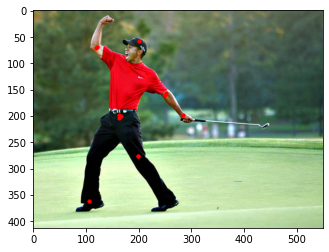

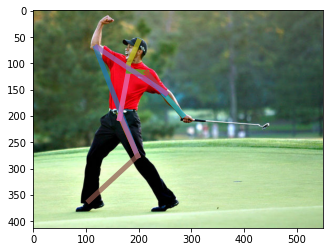

In [29]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)